In [282]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt

## 1a

In [283]:
# Dynamics
def state_model(x, a):
    '''
        f(x) = a*x
    '''
    return x*a

def observ_model(x):
    '''
        g(x) = sqrt(x^2+1)
    '''
    return np.sqrt(x**2 + 1)
    
def x_propagating(x,a, e):
    '''
        x_(k+1) = f(x_k) + e_k
    '''
    return state_model(x,a) + e

def y_update(x, v):
    '''
        y_k = g(x_k) + v_k
    '''
    return observ_model(x) + v

In [349]:
seed = 20
np.random.seed(seed)
a0 = -1 
N=100
var_e = 1
var_v = 1/2
e = np.random.normal(0, np.sqrt(var_e), N)
v = np.random.normal(0, np.sqrt(var_v), N)
x = np.array([np.random.normal(1, np.sqrt(2), 1)])

for i in range(N):
    x = np.append(x, x_propagating(x[i], a0, e[i]))

# Observations
D = np.hstack([y_update(x[i+1], v[i]) for i in range(N)])

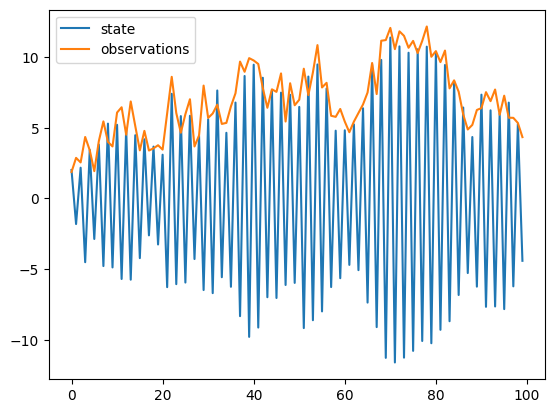

In [350]:
ts = np.arange(N)
plt.plot(ts, x[1:], label = "state")
plt.plot(ts, D, label = "observations")
plt.legend()

## 1 b)
In b, the state will be expanded to [x, a]. We want to estimate mu_a and var_a

In [413]:
def predict_mu(mu):#, x, a):
    return np.array([mu[1] * mu[0], mu[1]])

def predict_cov(mu, cov, R):
    A = np.array([[mu[1], mu[0]], [0, 1]]) #, dtype='float64') #jacobian matrix of f(x)
    return A @ cov @ A.T + R

def C(mu):
    ''' Jacobian vector of g(x_k) (size 1x2)
    '''
    return np.array([mu[0]/np.sqrt(mu[0]**2 + 1), 0])

def K(mu, cov, Q):
    '''Calculate Kalman gain (size 2x1)
    '''
    return cov @ C(mu).transpose() / (C(mu)@ cov @ C(mu).transpose() + Q)

def update_mu(D_k, mu, cov, Q):
    return mu + K(mu, cov, Q) * (D_k - observ_model(mu[0]))

def update_cov(mu, cov, Q):
    print("check cov update\n", np.identity(2) - K(mu, cov, Q) @ C(mu))
    return (np.identity(2) - K(mu, cov, Q) @ C(mu)) @ cov

In [424]:
# Initialization
np.random.seed(seed)
mu_0 = np.array([1, -3.5])
cov_0 = np.array([2, 1])
a = np.random.normal(mu_0[1], np.sqrt(cov_0[1]) , 1)
x = np.random.normal(mu_0[0], np.sqrt(cov_0[0]) , 1)


R = np.diag([1, 0.001])
Q = var_v

mu = mu_0 
cov = np.diag(cov_0).reshape(2,2,1)
mu_updated = np.zeros((1,2))
cov_updated = np.zeros((2,2,1))

In [425]:
for i in range(N-1):
    if (i == 0):
        mu_k = mu_0 
        cov_k = cov[:,:,i]
    else:
        mu_k = mu_updated[i,:]
        cov_k = cov_updated[:,:,i]
    print("\ncov_k", cov_k)
    print("cov_k+1", predict_cov(mu_k, cov_k, R))

    cov = np.concatenate((cov, np.expand_dims(predict_cov(mu_k, cov_k, R), axis =2)), axis=2)
    mu = np.vstack([mu, predict_mu(mu_k)])
    
    mu_updated = np.vstack([mu_updated, update_mu(D[i], mu[i+1,:], cov[:,:,i+1], Q)])
    cov_updated = np.concatenate((cov_updated, np.expand_dims( update_cov(mu[i+1,:], cov[:,:,i+1], Q), axis = 2) ), axis =2)

    print("update cov", cov_updated[:,:,i+1])

mu_updated = np.delete(mu_updated,0, axis =0)
cov_updated = np.delete(cov, 0, axis = 2) 




cov_k [[2 0]
 [0 1]]
cov_k+1 [[26.5    1.   ]
 [ 1.     1.001]]
check cov update
 [[ 0.02 -0.98]
 [-0.98  0.02]]
update cov [[ -0.45     -0.96098]
 [-25.95     -0.95998]]

cov_k [[ -0.45     -0.96098]
 [-25.95     -0.95998]]
cov_k+1 [[-163.64486       4.92559373]
 [  90.68551027   -0.95898   ]]
check cov update
 [[-0.00315557 -1.00315557]
 [-1.00315557 -0.00315557]]
update cov [[-90.45528204   0.94646308]
 [163.87508823  -4.93811066]]

cov_k [[-90.45528204   0.94646308]
 [163.87508823  -4.93811066]]
cov_k+1 [[-1076.64265249   -15.10230546]
 [ -295.27419399    -4.93711066]]
check cov update
 [[-4.85734726e-04 -1.00048573e+00]
 [-1.00048573e+00 -4.85734726e-04]]
update cov [[ 295.94058165    4.9468445 ]
 [1077.30904014   15.1120393 ]]

cov_k [[ 295.94058165    4.9468445 ]
 [1077.30904014   15.1120393 ]]
cov_k+1 [[ 3250.65528129   -41.48718711]
 [-1208.16363963    15.1130393 ]]
check cov update
 [[ 1.76549939e-04 -9.99823450e-01]
 [-9.99823450e-01  1.76549939e-04]]
update cov [[ 1208.524

(-500.0, 500.0)

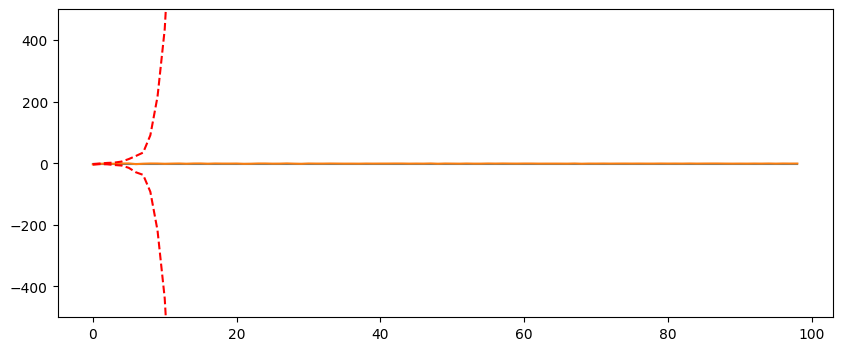

In [430]:
ts = np.arange(N-1)
plt.figure(figsize=(10,4))
plt.plot(ts, a0*np.ones(N-1))
plt.plot(ts, mu_updated[:,1])
plt.plot(mu_updated[:,1] - np.sqrt(abs(cov_updated[1,1,:])), '--r')
plt.plot(mu_updated[:,1] + np.sqrt(abs(cov_updated[1,1,:])), '--r')
# plt.fill_between(ts, mu_updated[:,1] - np.sqrt(cov_updated[1,1,:]), mu_updated[:,1] + np.sqrt(cov_updated[1,1,:]), alpha=.6, color="orange")
plt.ylim(-500, 500)


## Somethings wrong with the covariance matrix. Mu seems to converge to ground-truth, but variances cannot